In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
import numpy as np
from sklearn.metrics import make_scorer, f1_score
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from keras import regularizers
from keras.callbacks import EarlyStopping

import random
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


2023-07-02 11:00:23.232333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

In [3]:
df_encoded = pd.read_csv("data/encoded_data.csv", sep="\t")
df = pd.read_csv("data/combined_dataframe_clean.csv", sep="\t")

## Split dataframe

In [4]:
X_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(df_encoded, df['GoodPitStop'], test_size=0.3, random_state=4815)
X_train_HP, X_test_HP, y_train_HP, y_test_HP = train_test_split(df_encoded, df['HasPitLap'], test_size=0.3, random_state=4815)

## Functions

In [5]:
def plot_NNN(name, h, EPOCHS):
    LOSS = 0; F1 = 1
    training = np.zeros((2, EPOCHS))
    testing = np.zeros((2, EPOCHS))
    training[LOSS] = h.history['loss']
    testing[LOSS] = h.history['val_loss']  # validation loss
    training[F1] = h.history['f1_m']
    testing[F1] = h.history['val_f1_m']  # validation accuracy
    epochs = range(1, EPOCHS + 1)
    fig, axs = plt.subplots(1, 2, figsize=(17, 5))
    training_color = "#0072B2"  # Set the color for training
    testing_color = "#009E73"  # Set the color for testing
    axs[LOSS].plot(epochs, training[LOSS], color=training_color, label='Training loss')
    axs[LOSS].plot(epochs, testing[LOSS], color=testing_color, label='Test loss')
    axs[F1].plot(epochs, training[F1], color=training_color, label='Training f1')
    axs[F1].plot(epochs, testing[F1], color=testing_color, label='Test f1')
    for i in range(2):
        axs[i].set_title('Training and test ' + ['loss', 'f1'][i])
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(['loss', 'f1'][i])
        axs[i].legend()
    plt.savefig("img/results/" + name, dpi=300, bbox_inches='tight')

In [6]:
def f1_m(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Handle Class Imbalance

Class Weights: Adjust the class weights to give more importance to the minority class during training. The class_weight parameter can be passed to the Keras model.

In [7]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_HP), y = y_train_HP)
class_weights_dict = dict(zip(np.unique(y_train_HP), class_weights))
class_weights_dict

{0.0: 0.514641598119859, 1.0: 17.574638844301766}

In [9]:
class_weights_GP = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_GP), y = y_train_GP)
class_weights_dict_GP = dict(zip(np.unique(y_train_GP), class_weights))
class_weights_dict_GP

{0: 0.514641598119859, 1: 17.574638844301766}

In [74]:
import tensorflow as tf

seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

# Has pit

## Grid search

In [97]:
# Function to create the model
def create_model(l2_value, dropout_rate, hidden_layers):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation='relu', kernel_regularizer=regularizers.l2(l2_value), input_shape=(X_train_HP.shape[1],)))
    model.add(Dropout(dropout_rate))

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=[f1_m])
    return model

random.seed(42)

# Create the Keras classifier for scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameters to search
hyperparameters = {
    'l2_value': [0.0001, 0.0005, 0.001],
    'dropout_rate': [0.2, 0.3, 0.4],
    'epochs': [20, 30, 40],
    'batch_size': [128, 256, 512],
    'hidden_layers': [[64, 64], [64, 64, 64], [128, 64, 32]]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='f1', cv=5)
grid_result = grid_search.fit(X_train_HP, y_train_HP)

# Print the best results
print("Best Score: ", grid_result.best_score_)
print("Best Hyperparameters: ", grid_result.best_params_)


/var/folders/zg/vx8l82y56zj94339h1sczjtw0000gn/T/ipykernel_7238/140926797.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


274/274 [==============================] - 1s 2ms/step
Best Score:  0.5593415588281216
Best Hyperparameters:  {'batch_size': 256, 'dropout_rate': 0.2, 'epochs': 30, 'hidden_layers': [64, 64, 64], 'l2_value': 0.0001}


## Best HP

In [8]:
l2_value = 0.0001

model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value), input_shape=(X_train_HP.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [9]:
# Compile and train
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=[f1_m])
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train_HP, y_train_HP,
    validation_data=(X_test_HP, y_test_HP),
    epochs=30, batch_size=256,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/30
172/172 [==============================] - 6s 7ms/step - loss: 0.1702 - f1_m: 0.0017 - val_loss: 0.1141 - val_f1_m: 0.0000e+00
Epoch 2/30
172/172 [==============================] - 1s 5ms/step - loss: 0.1105 - f1_m: 0.0191 - val_loss: 0.1008 - val_f1_m: 0.0443
Epoch 3/30
172/172 [==============================] - 1s 5ms/step - loss: 0.1000 - f1_m: 0.1472 - val_loss: 0.0950 - val_f1_m: 0.2627
Epoch 4/30
172/172 [==============================] - 1s 5ms/step - loss: 0.0955 - f1_m: 0.2434 - val_loss: 0.0918 - val_f1_m: 0.2774
Epoch 5/30
172/172 [==============================] - 1s 5ms/step - loss: 0.0891 - f1_m: 0.3437 - val_loss: 0.0870 - val_f1_m: 0.3815
Epoch 6/30
172/172 [==============================] - 1s 5ms/step - loss: 0.0861 - f1_m: 0.3926 - val_loss: 0.0845 - val_f1_m: 0.3989
Epoch 7/30
172/172 [==============================] - 1s 5ms/step - loss: 0.0829 - f1_m: 0.4195 - val_loss: 0.0820 - val_f1_m: 0.4618
Epoch 8/30
172/172 [==============================] - 1s 4

587/587 [==============================] - 1s 1ms/step
F1 score: 0.593103448275862
Number epoch: 30


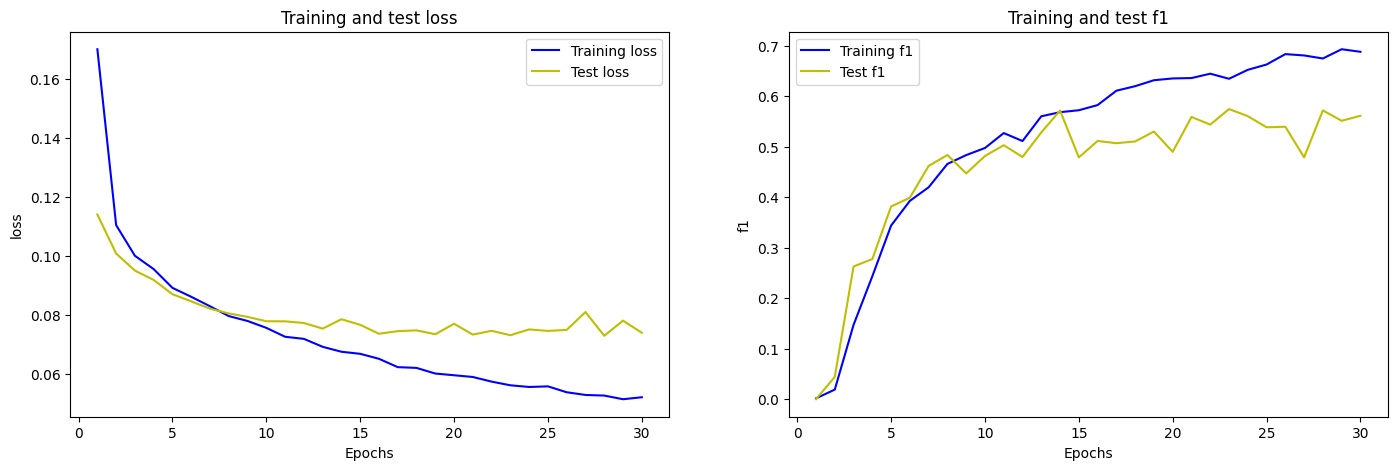

In [10]:
y_pred = model.predict(X_test_HP)
y_pred = np.round(y_pred)
f1 = f1_score(y_test_HP, y_pred)
epoch = len(history.history['loss'])
print('F1 score:', f1)
print('Number epoch:', epoch)
plot_NNN(history, EPOCHS = epoch)

F1 score: 0.593103448275862
Number epoch: 30


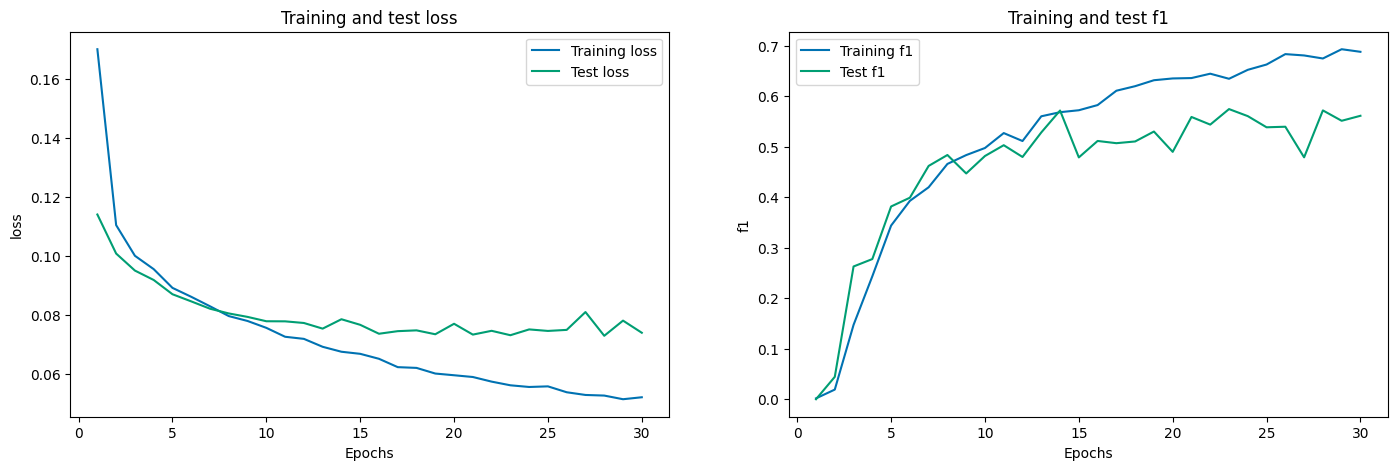

In [21]:
print('F1 score:', f1)
print('Number epoch:', epoch)
plot_NNN('ANN_HP', history, EPOCHS = epoch)

# Good Pit

In [10]:
# Function to create the model
def create_modelGP(l2_value, dropout_rate, hidden_layers):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation='relu', kernel_regularizer=regularizers.l2(l2_value), input_shape=(X_train_HP.shape[1],)))
    model.add(Dropout(dropout_rate))

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=[f1_m])
    return model

random.seed(42)

# Create the Keras classifier for scikit-learn
model = KerasClassifier(build_fn=create_modelGP, verbose=0)

# Define the hyperparameters to search
hyperparameters = {
    'l2_value': [0.0001],
    'dropout_rate': [0.2, 0.3, 0.4],
    'epochs': [20, 30, 40],
    'batch_size': [128, 256],
    'hidden_layers': [[64, 64, 64], [128, 64, 32]]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=hyperparameters, scoring='f1', cv=5)
grid_result = grid_search.fit(X_train_GP, y_train_GP)

# Print the best results
print("Best Score: ", grid_result.best_score_)
print("Best Hyperparameters: ", grid_result.best_params_)

/var/folders/zg/vx8l82y56zj94339h1sczjtw0000gn/T/ipykernel_5961/3183404445.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_modelGP, verbose=0)


274/274 [==============================] - 1s 3ms/step
Best Score:  0.35972764804509333
Best Hyperparameters:  {'batch_size': 256, 'dropout_rate': 0.4, 'epochs': 40, 'hidden_layers': [128, 64, 32], 'l2_value': 0.0001}


## Best HP

In [76]:
l2_value = 0.0001

model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value), input_shape=(X_train_GP.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_value)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [77]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=[f1_m])
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
historyGP = model.fit(
    X_train_GP, y_train_GP,
    validation_data=(X_test_GP, y_test_GP),
    epochs=30, batch_size=256,
    verbose=0,
    callbacks=[early_stopping]
)


587/587 [==============================] - 1s 2ms/step
F1 score: 0.3605769230769231
Number epoch: 24


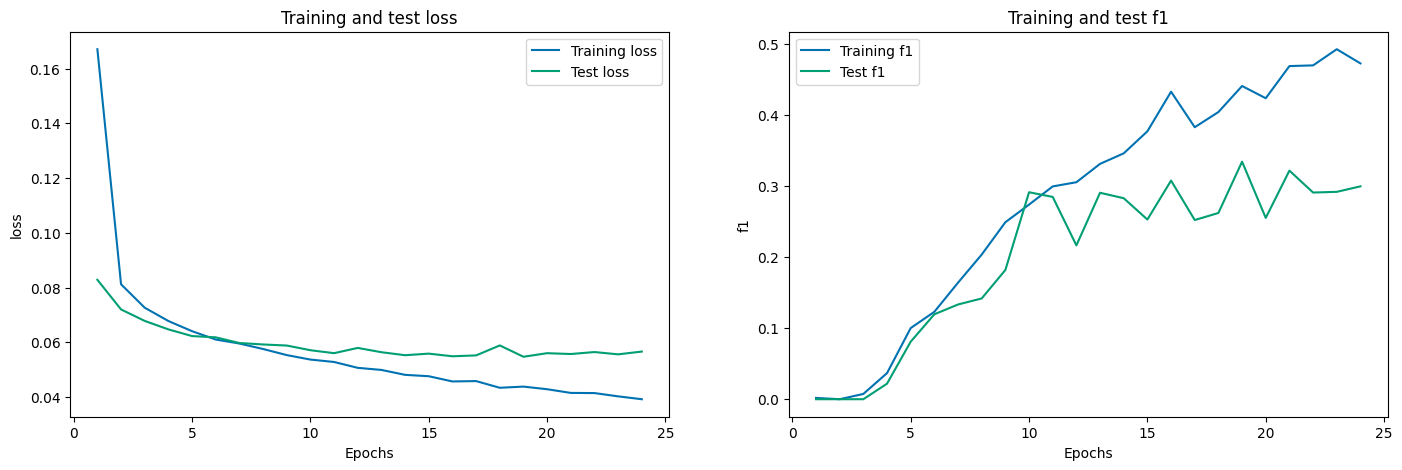

In [78]:
y_predGP = model.predict(X_test_GP)
y_predGP = np.round(y_predGP)
f1_GP = f1_score(y_test_GP, y_predGP)
epoch_GP = len(historyGP.history['loss'])
print('F1 score:', f1_GP)
print('Number epoch:', epoch_GP)
plot_NNN('ANN_GP', historyGP, EPOCHS = epoch_GP)